<a href="https://colab.research.google.com/github/leesuyee/ups_nrsc490_tutorial/blob/main/NRSC_490_Tutorial_Credit_Assignment_During_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>How do neuron interactions change after learning? </h2>
<h2> Credit Assignment During Learning: Data Access Tutorial


---

Sept 24, 2025

NRSC 490

University of Puget Sound

Su-Yee Lee, Saskia de Vries, Marina Garrett, Kayvon Daie, Marton Rozsa

# **Overview**
    
In this tutorial, we'll use neural activity data collected from mouse primary motor cortex before, during, and after animals learn a brain-computer interface task to address the following question: **How do neuron interactions change after learning?**

The data we're working with is part of the ongoing [Credit Assignment During Learning](https://www.allenneuraldynamics.org/projects/credit-assignment-during-learning)
project at the Allen Institute for Neural Dynamics. In this experiment, mice learn to control the activity of a specific neuron in order to receive rewards using a brain computer interface (BCI) paradigm. The activity of the conditioned neuron is read out in real time and is linked to the movement of a reward spot. Over a few trials, the activity of the conditioned neuron becomes coupled to the movement of the spout and the mouse learns to activate that neuron to move the spout towards its mouth to receive a reward. In contrast to other behavior tasks, this task enables us to study how learning of a single neuron can affect other cells in the network. See below for additional details of this dataset.

## **Background:**
 This experiment was designed to test competing models of learning rules—such as Hebbian learning,
 long-range input modulation, and biologically plausible approximations of error backpropagation—by
 directly measuring changes in neural activity and inferred connectivity during learning.
 The core task involved a closed-loop BCI paradigm in which a single neuron’s activity controlled
 a reward mechanism. Because the mapping from activity to behavior was fully defined by the experimenter,
  this paradigm enables ground-truth labeling of neurons as behaviorally causal (e.g., the conditioned neuron) versus merely correlated.
    
To probe learning-related circuit changes, cellular-resolution two-photon photostimulation
 was used to perturb neurons before and after learning. By analyzing evoked responses,
 researchers could infer the presence and strength of functional connections.
 Learning-induced changes in connectivity were then compared to predictions
 from recurrent neural network models trained with different plasticity rules,
 enabling discrimination between competing learning algorithms.
    
## **Experiment:**
Neural activity was recorded from layer 2/3 excitatory neurons in the primary motor cortex
of head-fixed mice using two-photon calcium imaging. Imaging was performed over multiple days
 as each animal learned and performed a BCI task. Each day, a new conditioned neuron (CN) was selected,
 the activity of this neuron was mapped in real-time to the position of a motorized reward port.
 To receive water rewards, mice had to learn to increase the activity of the conditioned neuron to move the port into reach.

In addition to the BCI task, the dataset includes photostimulation blocks in which individual or
groups of neurons were optogenetically stimulated to assess their causal influence on the surrounding network.
These connection mapping sessions were repeated daily to measure how connectivity changed as learning progressed.
 Imaging data were preprocessed using Suite2p or CellPose and include motion-corrected fluorescence traces,
 extracted ROIs, inferred spiking events, and stimulus-aligned behavioral data.
    
## **Approach: What analysis method can we use to address this question?**

One simple way to assess neuron interactions is by quantifying how correlated their activity patterns are. If neurons are consistently co-active, they are causally connected - likely connected directly or indirectly or receive shared input as part of an interacting circuit.

## **Goals:**

This tutorial focuses on data access, session structure (photostimulation and task periods), correlation structure among populations of neurons, and relating correlations to anatomical distance between cells.  
        



# **Resources**

For more details on the dataset, please refer to our online data book: https://allenswdb.github.io/physiology/ophys/BCI/BCI-overview.html

---

# **Set up environment**

Run the cell below to pip install the necessary packages. After install, restart the session and start at the next cell.

## **DO NOT RERUN THIS CELL**


In [ ]:
# Set up environment

!pip install pandas==2.2.3
!pip install aind-data-access-api==1.2.1
!pip install datetime

# Pin numpy to <2.0 for compatibility with hdmf/pynwb/hdmf-zarr
# Use matplotlib <3.9 since 3.10+ has breaking changes with Colab rendering
!pip install "numpy<2.0" "matplotlib<3.9" \
    hdmf==3.14.6 \
    hdmf-zarr==0.11.3 \
    pynwb==3.0.0 \
    s3fs \
    scikit-image \
    scipy


# **Import packages**

In [ ]:
#General imports
import os
import re
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.stats as stats
from skimage import measure
import matplotlib.pyplot as plt
import math
import s3fs

#PyNWB imports
from hdmf_zarr import NWBZarrIO

# **Import metadata**

For each experimental session, the experimenters collect rich metadata that reports important information about the equipment, materials, and methods used. The metadata records helps data users understand what happened during the experiment to select sessions of interest to analyze further.  

Run the hidden code cell below to import the metadata records from our database. Note that we have pre-selected sessions and metadata fields that are relevant for this tutorial. The code outputs a dataframe that contains information about the experimental session, such as the time/date of the session, the genotype and virus information of the subject, and other experimental parameters.

In [ ]:
#@title Run this cell to import metadata from DocDB

import pandas as pd
from datetime import datetime, date
from aind_data_access_api.document_db import MetadataDbClient

API_GATEWAY_HOST = "api.allenneuraldynamics.org"
DATABASE = 'metadata_index'
COLLECTION = 'data_assets'

docdb_api_client = MetadataDbClient(
   host=API_GATEWAY_HOST,
   database=DATABASE,
   collection=COLLECTION,
)
print(docdb_api_client._base_url)

aggregate = [
  {
    "$match": {
      "session.session_type": "BCI single neuron stim",
      "data_description.data_level": "derived",
      "processing.processing_pipeline.data_processes.start_date_time":{"$gte":"2025-08-03"}
    }
  },
  {
    "$project": {
      "name": 1,
      "subject_id": "$data_description.subject_id",
      "genotype": "$subject.genotype",
      "virus": "$procedures.subject_procedures.procedures.injection_materials.name",
      "date_of_birth": "$subject.date_of_birth",
      "sex": "$subject.sex",
      "session_type": "$session.session_type",
      "session_time": "$session.session_start_time",
      "stimulus_epochs": "$session.stimulus_epochs.stimulus_name",
      "project_name": "$data_description.project_name",
      "modality": "$data_description.modality.name",
      "targeted_structure": "$session.data_streams.stack_parameters.targeted_structure",
      "session_number": {
        "$filter": {
          "input": "$session.stimulus_epochs",
          "as": "epoch",
          "cond": { "$eq": ["$$epoch.stimulus_name", "single neuron BCI conditioning"] }
        }
      },
      "ophys_fov": {
            '$map': {
                'input': '$session.data_streams',
                'as': 'stream',
                'in': {
                    '$map': {
                            'input': '$$stream.ophys_fovs',
                            'as': 'fov',
                            'in': '$$fov.notes'
                    }
                }
            }
        },
     "magnification": "$session.data_streams.stack_parameters.magnification",
    }
  },
  {
    "$project": {
      "name": 1,
      "subject_id": 1,
      "genotype": 1,
      "virus": 1,
      "date_of_birth": 1,
      "sex": 1,
      "session_type": 1,
      "session_time": 1,
      "stimulus_epochs": 1,
      "project_name": 1,
      "modality": 1,
      "targeted_structure": 1,
      "session_number": { "$arrayElemAt": ["$session_number.session_number", 0] },
      "ophys_fov": 1,
      "magnification": 1
    }
  },
  {'$unwind': {'path': '$ophys_fov', 'preserveNullAndEmptyArrays': False}},
  {'$unwind': {'path': '$ophys_fov', 'preserveNullAndEmptyArrays': False}},
  {'$unwind': {'path': '$virus', 'preserveNullAndEmptyArrays': False}},
  {'$unwind': {'path': '$virus', 'preserveNullAndEmptyArrays': False}},
  {'$unwind': {'path': '$virus', 'preserveNullAndEmptyArrays': False}},
  {'$unwind': {'path': '$modality', 'preserveNullAndEmptyArrays': False}},
  {'$unwind': {'path': '$targeted_structure', 'preserveNullAndEmptyArrays': False}},
  {'$unwind': {'path': '$magnification', 'preserveNullAndEmptyArrays': False}}

]

records = docdb_api_client.aggregate_docdb_records(
    pipeline = aggregate,
)


metadata = pd.DataFrame(records)
metadata = metadata.drop_duplicates(subset="name")

metadata['session_date'] = metadata.apply(lambda x: datetime.fromisoformat(x['session_time']).date(), axis=1)
metadata['session_time'] = metadata.apply(lambda x: datetime.fromisoformat(x['session_time']).time(), axis=1)
metadata['date_of_birth'] = metadata.apply(lambda x: datetime.strptime(x['date_of_birth'], '%Y-%m-%d').date(), axis=1)
metadata['age'] = metadata.apply(lambda x: (x['session_date'] - x['date_of_birth']).days, axis=1)

order = ['project_name','session_type','_id','name','subject_id','genotype','virus','date_of_birth',\
         'sex','modality','session_date','age','session_time','targeted_structure','ophys_fov','session_number']
metadata = metadata[order]
metadata

# 08/24/25 fix - Remove problem metadata rows
problem_assets = [
    "single-plane-ophys_731015_2025-01-28_17-40-57_processed_2025-08-04_04-38-08",
    "single-plane-ophys_772414_2025-02-04_13-21-29_processed_2025-08-12_06-14-42"
]

metadata = metadata[~metadata["name"].isin(problem_assets)]

print('Successfully imported metadata from DocDB')

# **Metadata Overview**

Let's look at the metadata dataframe. Below are full descriptions for the columns in the metadata dataframe.

| Column    | Description |
| -------- | ------- |
| id | data asset id |
| name | filename of data asset (raw) |
| subject_id| numerical id for animal subject  |
| session_time |  experiment date (%Y-%m-%d %H:%M:%S)   |
| session_type   |  experiment identifier  |
| genotype  | subject genotype   |
| virus   | injected virus type  |
| ophys_fov   | field of view identifier  |
| session_number    | behavior training session number (days)   |


In [ ]:
metadata.head()

In [ ]:
metadata.columns

## **Pandas Basics**

Pandas DataFrames are 2 dimensional tables with columns and rows, similar to an Excel spreadsheet.

We can access a specific column using dot notation.

In [ ]:
metadata.name

We can also use square brackets with the string of the column name inside, like this. (Also, we can add .head() at the end to show just the top 5 rows)

In [ ]:
metadata['name'].head()

To access data for a specific row, use .iloc and an index number or a range of index numbers.

In [ ]:
metadata.iloc[0]

We can select for a particular column AND rows to slice the metadata in particular ways

In [ ]:
metadata.name.iloc[0:10]

We can also use operations to filter data for specific conditions. For example, let's say I only want to look at data for subjects >200 days old.  

First, I take the DataFrame, then add square brackets with my conditional statement to filter that DataFrame. I use dot notation to only return the age column.

In [ ]:
metadata[metadata.age >= 200].age

Adding `.values` to the end of your code will extract only the raw data, like so:

In [ ]:
metadata[metadata.age >= 200].age.values

## Pandas Resources

For more information on pandas operations, refer to the Pandas [documentation](https://pandas.pydata.org/docs/user_guide/10min.html) or this [Pandas cheatsheet](https://drive.google.com/file/d/1umRjn86wiV_zMqt_oW6BSncmsHXvfDq3/view)

## **What can we learn from the Metadata DataFrame?**

In addition to calling specific columns and rows to get specific information from the dataframe, we can apply useful Python and Pandas functions to quantify the data we extracted. We can answer questions like:

What unique brain regions were recorded from in this dataset?

In [ ]:
metadata.targeted_structure.unique()

Or... What age ranges were used in this dataset?

First, we can get just the age column of data. Then, we pass that column of data into the plt.hist function, which creates a histogram of the data.


In [ ]:
plt.hist(metadata.age)
plt.xlabel('Age (days', fontsize = 18)
plt.ylabel('Number of sessions', fontsize = 18)
plt.title('Age distribution', fontsize = 18)

Also... how many sessions were collected per mouse?


In [ ]:
metadata.subject_id.value_counts()

What other information can you find using the metadata? How would you programmatically access and quantify that information?

---

# **Select a session of interest**

Using the metadata dataframe, let's select a mouse and session of interest.

In [ ]:
# # Pick a mouse
subject_ids = np.sort(metadata['subject_id'].unique())
subject_id = subject_ids[3]
print('Selected subject_id is', subject_id)

# Look at its metadata, sorted by 'session_number'
this_mouse_metadata = metadata[metadata['subject_id']==subject_id].sort_values(by='session_number')
this_mouse_metadata.head()

In [ ]:
# # Let's pick an example session for this mouse
session_name = this_mouse_metadata.name.values[-1]
print('Selected session is', session_name)

# **Load session data (NWB) from S3**
    
The data for each session is packaged into a Neurodata Without Borders (NWB) file and stored in a publicly accessible bucket on S3.

We can access the data via S3 web link. The `get_s3_link` function below will construct the full S3 path link for a given `session_name`.

The NWB files are packaged using a Zarr backend to compress the data for cloud-friendly storage. To load the files, we'll pass the full S3 link to the the [`NWBZarrIO`](https://pynwb.readthedocs.io/en/stable/tutorials/advanced_io/plot_zarr_io.html) package from `hdmf-zarr`.

In [ ]:
# @title Import get_s3_link function
def get_s3_link(session_name):
  """
  Finds the S3 link path that routes to the session data

  Parameters:
  session_name: str, name of session

  Outputs:
  s3_link: str, S3 link path

  """

  # List top-level of the bucket
  s3 = s3fs.S3FileSystem(anon=True)
  files = s3.ls('aind-open-data')

  # Get a specific data folder
  root_path = 'aind-open-data/'
  # construct full file path from aind-open-data + single-plane-ophys
  prefix = root_path + session_name + '/'
  experiment_files = s3.ls(prefix)
  print("Experiment folder contents:", experiment_files)

  # Search experiment_files for something that contains 'nwb'
  nwb_file = [f for f in experiment_files if "nwb" in f.lower()]
  print(nwb_file)

  full_s3_path = f's3://{nwb_file[0]}'
  print(f"Loading NWB file from: {full_s3_path}")

  return full_s3_path


In [ ]:
full_s3_path = get_s3_link(session_name)

# Load NWB File using NWBZarrIO
io = NWBZarrIO(path=full_s3_path, mode='r', storage_options={'anon': True})
nwbfile = io.read()

# **Neurodata Without Borders (NWB) Overview**

NWB files are a standardized file format for systems neuroscience experiments. They are formatted similarly to hdf5 containers, with data stored in a hierarchical format made up of distinct containers.


In [ ]:
nwbfile

---

# **What data is available? How was it processed?**

The data packaged in the NWB file has been **processed**. What does this entail?

# **1. Raw data**

During each recording session, videos were collected from the 2-photon microscope which captured changes in fluorescent activity from a population of neurons in primary motor cortex. Using genetic labelling strategies, neurons expressed GCaMP, a genetically encoded calcium indicator which causes neurons to fluoresce when calcium levels rise in the cell. The fluorescent signal can be used as a readout of neuron activity.

While the NWB file does not contain the raw video itself, we can see the average projection of all the frames in the video for this session.

In [ ]:
average_image = nwbfile.processing["processed"].data_interfaces["images"].images["average_projection"].data[:]

# Plot average projection of images

# Set up figure
plt.figure(figsize=(8,6))

# Use imshow to plot the image
plt.imshow(average_image, cmap='gray', origin='upper', aspect='equal', vmax=0.25)
plt.title('Average Projection of Field of View')
plt.axis('off')

# **2. Image Segmentation**

In the average projection image, notice that there are hundreds of dim to bright, round circles. These are the somas of the neurons, which we use to read out neuron activity based on changes in fluorescence.

As part of processing, the videos are run through software like Suite2p or CellPose, which use machine learning to segment regions of interest (ROIs) that likely correspond to the somas. This process is called image segmentation.

The extracted ROIs (the outputs of Suite2p/CellPose) are represented as image masks, a HxW sparse array with non-zero values that define the spatial boundaries and intensity profiles of the ROIs. That data is contained in the **processed > processing > image segmentation > plane segmentations** container.

We'll load just the image masks for now and overlay with the average projection image.

In [ ]:
image_masks = nwbfile.processing["processed"].data_interfaces['image_segmentation'].plane_segmentations['roi_table'][:].image_mask
image_masks

# every row is an ROI

In [ ]:
# Plot ROI contours overlayed on average image

# Set up figure
plt.figure(figsize=(8,6))

# Plot average image
plt.imshow(average_image, cmap='gray', origin='upper', aspect='equal', vmax=0.25)
plt.title('ROI Contours Overlaid on Average Projection for Valid ROIs')
plt.axis('off')

# Overlay ROI contours
for mask in image_masks:
  mask_array = np.array(mask)
  # Find contours at a level that works well for binary masks
  contours = measure.find_contours(mask_array, level=0.5)

  for contour in contours:
    color = 'yellow'
    linewidth = 0.5

    # Plot contour (note: contour coordinates are in (row, col) format)
    plt.plot(contour[:, 1], contour[:, 0], color=color, linewidth=linewidth)

# Set the axis limits to match the image dimensions
plt.xlim(0, average_image.shape[1])
plt.ylim(average_image.shape[0], 0)  # Flip y-axis to match image coordinates

plt.tight_layout()
plt.show()

# **3. Cell classification**

Notice that there are 1000s of ROIs in this image. Not all of them look like somas. Depending on the parameters used in data processing (and the data itself), Suite2p/CellPose can pick up a lot of ROIs or just a few. After image segmentation, our processing pipeline evaluates the ROIs to determine the likelihood that they are somas or something else, like a dendrite or vessel.

The function below will filter out ROIs that are not somas and return a table with just the clean ROIs (and ensures that any experimentally relevant neurons are included).

In [ ]:
# @title Import soma filtering function
def filter_roi_table(nwbfile) -> pd.DataFrame:
  """
  Parameters:
  nwbfile: NWBFile object

  Outputs:
  filtered_roi_table: pandas DataFrame, filtered ROI table with only ROIs that pass soma classifier and photostimulated and conditioned neurons
  """
  # Get photostim and cn indices from tables in NWB file
  photostim_ids = nwbfile.stimulus["PhotostimTrials"].to_dataframe().closest_roi.values
  cn_id = nwbfile.stimulus["Trials"].to_dataframe().closest_roi.values
  roi_table = nwbfile.processing["processed"].data_interfaces["image_segmentation"].plane_segmentations["roi_table"][:]

  missing_ids = np.unique(np.concatenate([photostim_ids, cn_id]))

  # Check which indices did not pass soma detection
  add_ids = []
  for idx in missing_ids:
    if roi_table.iloc[idx].is_soma == 0:
      add_ids.append(idx)
    else:
      continue

  # Filter roi table for those that pass is_soma and for indices of missing ids
  filtered_roi_table = roi_table[roi_table.is_soma==1]
  # to filtered_roi_table add in indices from roi table that correspond to missing ids
  filtered_roi_table = pd.concat(
    [filtered_roi_table, roi_table.iloc[add_ids]],
    ignore_index=False  # reindex rows if you don’t care about preserving original indices
  )

  filtered_roi_table = filtered_roi_table[['image_mask']]

  return filtered_roi_table

Here is a description of the columns in the ROI table (filtered_roi_table):

| Column    | Description |
| -------- | ------- |
| id | index in dff array that corresponds to the ROI |
| image_mask  | HxW sparse array defining image masks|

In [ ]:
filtered_roi_table = filter_roi_table(nwbfile)
filtered_roi_table

Now, let's visually inspect only the ROIs that pass the soma classification we just ran.

In [ ]:
# Plot ROI contours overlayed on average image

# Set up figure
plt.figure(figsize=(8,6))

# Plot average image
plt.imshow(average_image, cmap='gray', origin='upper', aspect='equal', vmax=0.25)
plt.title('ROI Contours Overlaid on Average Projection for Valid ROIs')
plt.axis('off')

# Overlay ROI contours
for mask in filtered_roi_table.image_mask:
  mask_array = np.array(mask)
  # Find contours at a level that works well for binary masks
  contours = measure.find_contours(mask_array, level=0.5)

  for contour in contours:
    color = 'yellow'
    linewidth = 0.5

    # Plot contour (note: contour coordinates are in (row, col) format)
    plt.plot(contour[:, 1], contour[:, 0], color=color, linewidth=linewidth)

# Set the axis limits to match the image dimensions
plt.xlim(0, average_image.shape[1])
plt.ylim(average_image.shape[0], 0)  # Flip y-axis to match image coordinates

plt.tight_layout()
plt.show()

# **4. DFF**

For each ROI, the change in fluorescence (df) over a baseline (F) is calculated, resulting in the dff traces.

First, the change in fluorescence within each ROI is calculated. Then, the signal is corrected for noise by subtracting the local neuropil signal. The corrected signal is then demixed from potentially overlapping ROIs. Finally, the corrected change in fluorescence signal is normalized over baseline fluorescence (median fluorescence over a 60s time window centered around each time point).

The final "dff" data is stored in the **processing** container of the NWB file.

Let's load 'dff', nframes x nrois array.


In [ ]:
dff_traces = nwbfile.processing["processed"].data_interfaces["dff"].roi_response_series["dff"].data
print('dff shape (nframes, nrois):',np.shape(dff_traces))


Let's make an array for the timestamps for this trace using the `imaging_rate` - the rate at which the 2P frames were acquired

In [ ]:
#get imaging frame rate from the NWB file in Hz
frame_rate = nwbfile.imaging_planes["processed"].imaging_rate

#convert to seconds
time_step = 1/frame_rate

#create equally spaced timestamps array
n_frames = dff_traces.shape[0]
timestamps = np.linspace(0, (time_step*n_frames), num=n_frames)

# **Plot a neuron activity trace**
Let's plot the dff trace over time for a select ROI. What do you notice about this neuron's activity?

In [ ]:
# Pick an ROI
ROI = 2221

# Plot dff trace for selected ROI
plt.figure(figsize=(10,4))
plt.plot(timestamps, dff_traces[:, ROI], color='black')

plt.ylabel('dF/F')
plt.xlabel('Time (s)')
plt.title('dF/F for ROI '+str(ROI))
plt.show()

## **Exercise**

Try selecting a different ROI and plotting the dff trace. How does the signal compare to the previous plot?

In [ ]:
# @title Click to show answer

# Pick an ROI with a valid soma
ROI = 5 # change the value here

# Plot dff trace for selected ROI
plt.figure(figsize=(10,4))
plt.plot(timestamps, dff_traces[:, ROI], color='black')
plt.ylabel('dF/F')
plt.xlabel('Time (s)')
plt.title('dF/F for ROI '+str(ROI))
plt.show()

## **Exercise**

Try plotting dff over a narrower time window, say 100 seconds. Pick a region with interesting activity to inspect more closely.

In [ ]:
# @title Click to show answer
# Pick an ROI with a valid soma
ROI = 2221

# Plot dff trace for selected ROI
plt.figure(figsize=(10,4))
plt.plot(timestamps, dff_traces[:, ROI], color='black')

# Add xlim to plot a particular window of x
plt.xlim(100, 200)
plt.ylabel('dF/F')
plt.xlabel('Time (s)')
plt.title('dF/F for ROI '+str(ROI))
plt.show()

# **5. Epochs Table**

DFF reports the continuous neural activity trace over the entire session. Let's add some context to the plot!

The epochs table contains the start and stop times/frames for each experimental epoch. The start and stop frames can be used to index into the 2-photon timeseries, since they are temporally aligned.

The epochs table is contained in the **intervals** container of the NWB file. The table is stored as a DynamicTable, which we convert to a Pandas DataFrame using `to_dataframe`, for better accessibility.


In [ ]:
# Load the epochs table from the NWB file
epoch_table = nwbfile.intervals["epochs"].to_dataframe()
epoch_table

# **Plot neuron activity trace with epochs overlaid**

Now plot the dF/F trace for the ROI we selected together above with the stimulus epochs overlaid in color. Does its activity change across epochs?


In [ ]:
epoch_table

In [ ]:
# Pick an ROI
ROI = 2221

# Set up figure
plt.figure(figsize=(10, 4))

# Plot dff trace
plt.plot(timestamps, dff_traces[:, ROI], color="black")

# Get epoch info
epoch_table = nwbfile.intervals["epochs"].to_dataframe()
stimulus_names = epoch_table.stimulus_name.unique()

# Define fixed colors
color_map = {
    "spont": "orange",
    "photostim": "purple",
    "other": "green"
}

# Plot shaded blocks for each stimulus epoch
for stimulus_name in stimulus_names:
    stim_epoch = epoch_table[epoch_table.stimulus_name == stimulus_name]

    # Assign color based on name
    lname = stimulus_name.lower()
    if "spont" in lname:
        color = color_map["spont"] # All spontaneous epochs == orange
    elif "photostim" in lname:
        color = color_map["photostim"] # All photostim epochs == purple
    else:
        color = color_map["other"] # Other (BCI) == green

    plt.axvspan(stim_epoch.start_time.values[0], stim_epoch.stop_time.values[0], color=color, alpha=0.3, label=stimulus_name)

# Labels and title
plt.ylabel("dF/F")
plt.xlabel("Time (s)")
plt.title(f"Stimulus epochs and dF/F for ROI {ROI}")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()


## **Discuss**

Referring back to the previous exercise where you zoomed in on a section of the dff trace, what epoch does this section fall into? What was happening during the experiment that could explain the dynamics of the signal?

# **6. Trials tables**

The trials tables tells you what happened in each epoch on a trial-by-trial basis. These tables are found in the **stimulus** container of the NWB file.


In [ ]:
# These are the available stimulus tables
nwbfile.stimulus.keys()

# **6a. Trials tables: optogenetic photostimulation trials**
    
The `PhotostimTrials` table contains information about each 2p optogenetic stimulation trial. Optogenetic stimulation is used in this experiment to probe connectivity between neurons. In each trial, one neuron is stimulated, and all other neurons are recorded. Neurons with short latency responses after the optostim can be considered to be causally connected.
    
Below is a decription for each of the columns in the photostim trials table:

| Column    | Description |
| -------- | ------- |
| start_time  | stimulus start (s)  |
| stop_time | stimulus end (s)   |
| start_frame | stimulus start (frame)     |
| stop_frame    | stimulus end (frame)  |
| tiff_file   | data source file name  |
| stimulus_name    | stimulus name   |
| laser_x    | x coordinate of stimulated neuron (pixel)   |
| laser_y    | y coordinate of stimulated neuron (pixel)  |
| power    | stimulus intensity (mW)  |
| duration    | trial duration (s)  |
| stimulus_function    | stimulus template   |
| group_index    | identity of stimulated neuron(s)   |
| closest_roi    | index in dff that corresponds to the photostimulated neuron   |


In [ ]:
photostim = nwbfile.stimulus["PhotostimTrials"].to_dataframe()
photostim.head()



# **Exercise:** Check the unique values of the `stimulus_name` column of the `PhotostimTrials` table.

Do they correspond to the stimulus names in the `epoch_table`?


In [ ]:
# @title Click to show answer
# Stimuli in photostim trials table
photostim['stimulus_name'].unique()

In [ ]:
# @title Click to show answer
# Compare to epochs
epoch_table.stimulus_name.unique()

# **6b. Trials tables: BCI behavior trials**
    
The behavior trials table contains information about what the mouse did during each trial, such as whether it licked or got a reward, and when in the trial these events happened. It also includes the ID of the conditioned neuron.
    
Here is a description of the columns of this table:

| Column    | Description |
| -------- | ------- |
| start_time  | trial start (s)  |
| stop_time | trial end (s)   |
| go_cue |  time of go cue relative to start time (s)   |
| hit   |  boolean of whether trial was hit   |
| lick_l  | lick times (s)   |
| reward_time   | reward delivery time (s)   |
| threshold_crossing_times    | time when reward port crossed position threshold (s)   |
| zaber_steps_times   | times when reward port moves  |
| tiff_file    | data source file name  |
| start_frame    | trial start (frame)  |
| stop_frame    | trial end (frame)  |
| conditioned_neuron_x    | coordinate for conditioned neuron (pixels)  |
| conditioned_neuron_y    | coordinate for conditioned neuron (pixels)  |
| closest_roi    | index in dff that corresponds to the conditioned neuron  |


# **Exercise:** Load the `Trials` table from the *<b>stimulus</b>* container, turn it into a dataframe called trials.
    
What happens during the BCI task epoch? What information is provided for each trial?


In [ ]:
# @title Click to show anwer

# Load the BCI trials table
trials = nwbfile.stimulus["Trials"].to_dataframe()
trials.head()


In [ ]:
# What info do we have for each trial?
trials.columns

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

What is the ROI ID of the conditioned neuron?

This ID refers to the index in the dff array that corresponds to the conditioned neuron.
        
</div>

In [ ]:
# The conditioned neuron ID is indicated by the 'closest_roi' column
trials.closest_roi.unique()

# **Exercise**

Plot the dff trace of the conditioned neuron during the BCI epoch.



In [ ]:
# @title Click to show answer
# Get the roi id for the conditioned neuron
ROI = trials.closest_roi.unique()

# Get time window for BCI epoch
start_f = epoch_table[epoch_table.stimulus_name == "BCI"].start_time.iloc[0]
stop_f = epoch_table[epoch_table.stimulus_name == "BCI"].stop_time.iloc[0]

# Plot dff trace for selected ROI
plt.figure(figsize=(10,4))
plt.plot(timestamps, dff_traces[:, ROI], color='black')

# Plot only defined time window
plt.xlim(start_f, stop_f)

plt.ylabel('dF/F')
plt.xlabel('Time (s)')
plt.title('dF/F for Conditioned Neuron During BCI Epoch')
plt.show()

## **Plot Conditioned Neuron activity aligned with behavior events**

The activity of a single neuron is used to control the movement of a lick port (actuated by a zaber motor) towards the mouse's face. Let's take a look at the activity of the conditioned neuron relative to some of the behavior events described in the "trials" table from before.

We'll plot the trial start (start_time), when the lickport moved (zaber_step_times), and the reward times (reward_time). Note that units for the zaber_step_times and reward_time is in seconds and is reported relative to the start of the trial.

In [ ]:
trials.head()

For plotting, let's build a list of all the times for each behavioral event.

For each trial, we need to get the event times for a given behavioral event and add the start_time of that trial to it.

In [ ]:
#create empty lists for the behavior events
lick_times = []
go_cues = []
rewards = []
threshold_crossing_times = []
zaber_step_times = []

#for each trial, add the event times to trial start and append to appropriate list
for index, row in trials.iterrows():
    lick_times.append(row.lick_L[np.isfinite(row.lick_L)] + row.start_time) # use isfinite to filter out nans
    zaber_step_times.append(row.zaber_step_times[np.isfinite(row.zaber_step_times)] + row.start_time)
    go_cues.append(row.go_cue + row.start_time)
    rewards.append(row.reward_time + row.start_time)
    threshold_crossing_times.append(row.threshold_crossing_times + row.start_time)

#reshape lick_times and zaber_step_times (this is needed because there is a list of times for each trial)
lick_times = np.hstack(lick_times)
zaber_step_times = np.hstack(zaber_step_times)

Let's plot all of the reward times. We can use `np.ones_like` to make an array of 1s the length of the number of values in the rewards list.

In [ ]:
plt.plot(rewards, np.ones_like(rewards), '|')

plt.xlabel("Time (s)")
plt.title("Reward times")

Now that we have the behavior events in absolute time, let's plot both the dff trace of the conditioned neuron and the behavior events.

In [ ]:
plt.figure(figsize=(12,6))

#plot the dff of the conditioned neuron
plt.plot(timestamps, dff_traces[:, ROI], color='gray', alpha = 0.6)

#plot the lick times, rewards, trial start times, and zaber steps
plt.plot(lick_times, np.ones_like(lick_times), 'g.', label="Licks")
plt.plot(rewards, np.ones_like(rewards), 'ro', label="Rewards")
#we'll put the zaber steps a little higher on the plot by multiplying the y-values by 2
plt.plot(zaber_step_times, np.ones_like(zaber_step_times)*2, '|', label="Zaber steps")
# plot the trial start times
plt.plot(trials.start_time.values, np.ones_like(trials.start_time.values), 'bo',linewidth = 5, label = "Trial start")

#add a legend
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("dF/F")

plt.xlim(1625,1700)
plt.ylim(-1,4)

---


# **How does neural activity change with learning?**

Now that we've walked through how to load the NWB file and extract the main data pieces. Let's go back to our original question - could the learning that happens during the BCI task epoch change the activity of the other neurons in the imaging plane?


How should we approach this question?

In [ ]:
# @title

# Assessing correlations in neural activity before and after learning!

# **Correlations**

Correlation coefficients are commonly used to evaluate if there's a linear relationship between two variables, or in this case, two neurons. Here, we will use Pearson Correlation, which is computed using the formula:



correlation_coefficient_formula.svg


If the two variables are positively correlated, a large response from cell A will be matched with a large response in cell B. If they are weakly correlated, the response size of cell A will have no relationship with the response size of cell B. And if they are negatively correlated, cell B will have small responses when cell A has large responses.

If two neurons are highly correlated, this could be due to a direct connection between the neurons or a shared input.



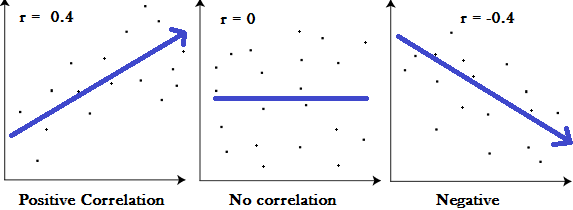




# **Implementation**

To assess how learning changes neural activity before and after learning, we'll take the good ROIs in the dataset and compare its activity to every other good ROI in the dataset. In other words, we'll compute pairwise correlation coefficients. We'll use the `corrcoef` function from numpy to help us out.

First, let's shape the data we need to run the function. Let's focus on the spontaneous activity epoch that occurred before and after learning as this gives us a neutral read out of neural activity.


# **Discuss**
What does spontaneous activity mean? Why is it useful?


# **Get dff for the spontaneous epochs**  
Let's shape the dff array to get the frame periods during the spontaneous epochs before and after learning (spont and spont_post, respectively).

Note that the epoch order and stimulus naming scheme can vary across sessions. Be sure to check the epoch table before doing any epoch-specific analyses.

In [ ]:
epoch_table

We want to index into the dff array in order to just choose the section that is during the spontaneous epochs. To index into an array, we need the index of the array that corresponds to the start_time and stop_time. We've already calculated this for you, and it's in the epoch (and trial) tables as the **start_frame** and **stop_frame** respectively.

In [ ]:
# Get the start and stop frames for the spontaneous periods before (spont) and after (spont_post) learning.
spontaneous_pre_start = epoch_table[epoch_table.stimulus_name == 'spont'].start_frame.values[0]
spontaneous_pre_stop = epoch_table[epoch_table.stimulus_name == 'spont'].stop_frame.values[0]

# The last spontaneous period is the last spontaneous epoch
spontaneous_post_start = epoch_table[epoch_table.stimulus_name == 'spont_post'].start_frame.values[0]
spontaneous_post_stop = epoch_table[epoch_table.stimulus_name == 'spont_post'].stop_frame.values[0]


In [ ]:
# Index into the dff traces array to limit to the relevant time points
dff_pre = dff_traces[spontaneous_pre_start:spontaneous_pre_stop, :]
# Transpose so shape is n_neurons x n_frames
dff_pre = dff_pre.T

print(dff_pre.shape)

dff_post = dff_traces[spontaneous_post_start:spontaneous_post_stop, :]
dff_post = dff_post.T
print(dff_post.shape)

Visualize the dFF traces for each spontaneous period as a heatmap.

In [ ]:
# Set up figure
plt.figure(figsize=(10, 6))

# Plot as heatmap
plt.imshow(
    dff_pre,
    vmin=0,
    vmax=5,
    cmap='magma',
    origin='lower',
    aspect='auto',
    interpolation='none'
)

plt.colorbar(label='dFF')
plt.xlabel('2P frames')
plt.ylabel('ROI ID')
plt.title('Spontaneous pre')


# **Exercise:** Repeat the same for spontaneous post epoch.


In [ ]:
# @title Click to show answer

# Set up figure
plt.figure(figsize=(10, 6))

# Plot as heatmap
plt.imshow(
    dff_post,
    vmin=0,
    vmax=5,
    cmap='magma',
    origin='lower',
    aspect='auto',
    interpolation='none'
)

plt.colorbar(label='dFF')
plt.xlabel('2P frames')
plt.ylabel('ROI ID')
plt.title('Spontaneous post')


# **Filter dff for valid somas**

Remember that not all of these dff traces are from valid somas, so we should filter the data we include in our correlations analysis. It also looks like there are some nans in the array that should be filtered out.


In [ ]:
filtered_dff_pre = dff_pre[filtered_roi_table.index.values, :] # Filter for rows in filtered_roi_table
mask = np.isnan(filtered_dff_pre).any(axis=1) # Filter out nans
filtered_dff_pre = filtered_dff_pre[~mask]
print('filtered dff pre shape (nframes, nrois):',np.shape(filtered_dff_pre))

filtered_dff_post = dff_post[filtered_roi_table.index.values, :] # Filter for rows in filtered_roi_table
mask = np.isnan(filtered_dff_post).any(axis=1) # Filter out nans
filtered_dff_post = filtered_dff_post[~mask]
print('filtered dff post shape (nframes, nrois):',np.shape(filtered_dff_post))

In [ ]:
# Plot filtered_dff_pre as a heatmap

# Set up figure
plt.figure(figsize=(10, 6))

# Use imshow to plot heatmap
plt.imshow(
    filtered_dff_pre,
    vmin=0,
    vmax=5,
    cmap='magma',
    origin='lower',
    aspect='auto',
    interpolation='none'
)
plt.colorbar(label='dFF')
plt.xlabel('2P frames')
plt.ylabel('ROI ID')
plt.title('Spontaneous pre')


In [ ]:
# Plot filtered_dff_post as a heatmap

# Set up figure
plt.figure(figsize=(10, 6))

# Use imshow to plot a heatmap
plt.imshow(
    filtered_dff_post,
    vmin=0,
    vmax=5,
    cmap='magma',
    origin='lower',
    aspect='auto',
    interpolation='none'
)
plt.colorbar(label='dFF')
plt.xlabel('2P frames')
plt.ylabel('ROI ID')
plt.title('Spontaneous post')


# **Discuss:** What do you notice about the spontaneous activity?

# **Quantifying correlations**

Now that we've gotten dff arrays for the spontaneous epochs that happened before and after the BCI task, let's compute pairwise correlations between all neurons in each epoch.

First, quantify the correlation between every cell pair's dff traces for the pre and post spontaneous periods using [np.corrcoef](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html).
    
We will save the output to two variables called `correlations_pre` and `correlations_post` so we can use them later in our analysis.

In [ ]:
correlations_pre = np.corrcoef(filtered_dff_pre)
correlations_post = np.corrcoef(filtered_dff_post)

correlations_pre.shape

Let's plot the matrix of correlations before learning as a heatmap.
</div>

In [ ]:
# Plot correlations pre as a heatmap
plt.imshow(
    correlations_pre,
    vmin=-0.1,
    vmax=0.1,
    cmap='RdBu',
    origin='lower',
    aspect='auto',
    interpolation='none'  # imshow uses a default smoothing, turn this off
)

plt.colorbar(label='Correlation')
plt.xlabel('ROI #')
plt.ylabel('ROI #')
plt.title('Correlations pre')


# **Exercise:** Repeat the same for the correlations after learning.

Did the correlations change?

In [ ]:
# @title  Click to show answer
# Plot correlations pre as a heatmap
plt.imshow(
    correlations_post,
    vmin=-0.1,
    vmax=0.1,
    cmap='RdBu',
    origin='lower',
    aspect='auto',
    interpolation='none'  # imshow uses a default smoothing, turn this off
)

plt.colorbar(label='Correlation')
plt.xlabel('ROI #')
plt.ylabel('ROI #')
plt.title('Correlations post')


# **Remove duplicate pairs**

To quantify differences in the distribution of pairwise correlation values, we only want to count each pair once and we dont want to include each cell's correlation to itself (which is always 1, along the diagonal).

We can use [`np.triu_indices`](https://numpy.org/devdocs/reference/generated/numpy.triu_indices.html), which will return the indices for the upper triangle above the kth diagonal. Then, we'll use these indices to filter our correlations_pre and post arrays.

In [ ]:
triu_indices = np.triu_indices(correlations_pre.shape[0], k = 1)
triu_indices # returns a tuple of 2 ndarrays of shape nframes

In [ ]:
# Now, filter correlations_pre and correlations_post for indices we just grabbed

pre_vals = correlations_pre[triu_indices[0], triu_indices[1]]
post_vals = correlations_post[triu_indices[0], triu_indices[1]]

# This flattens the array
print(correlations_pre.shape)
print(pre_vals.shape)

# **Plot the distribution of correlation values for spontaneous pre and spontaneous post.**

In [ ]:
# Define bin edges
bins = np.linspace(-0.1, 0.1, 100)

# Plot histograms
plt.hist(pre_vals, bins=bins, color='green', label='pre', histtype='step')
plt.hist(post_vals, bins=bins, color='purple', label='post', histtype='step')

plt.title('Correlations before and after BCI learning')
plt.xlabel('r value')
plt.ylabel('# cell pairs')
plt.xlim(-0.1, 0.1)
plt.legend()


# **Evaluate the pairwise correlations: run a t-test**

Did the correlations in neural activity change after the BCI task?

We can check for statistical differences in the distribution of pairwise correlations. We'll first flatten the matrix of correlations into a 1D array, then apply a t-test using [scipy.stats.ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html).

Are the distributions statistically different?

In [ ]:
# Calculate the mean of the pre and post distributions

print('mean pre:', pre_vals.mean())
print('mean post:', post_vals.mean())

In [ ]:
# Run the stats!
t, p_val = stats.ttest_ind(pre_vals, post_vals)
print(p_val)

In [ ]:
# what does this mean? if <0.05 then, yes

# **Exercise**

From the correlations arrays, get the correlations between the conditioned neuron and all other good ROIs. Plot the distribution of correlations before and after learning. Did the correlations change?

**Hint** From the original correlations_pre and correlations_post, subselect the data of interest. Since we're looking at the correlations of one neuron, we don't need to use np.triu to remove duplicates, but instead we do need to handle the self-correlations.

In [ ]:
# Calculate the means and stats here

In [ ]:
# @title Click to show answer

# Reshape data to get only dff for conditioned neuron index

# Get conditioned neuron index
cn_index = trials.closest_roi[0]

cn_correlations_pre = correlations_pre[cn_index,:]
cn_correlations_post = correlations_post[cn_index,:]

# Remove the self-correlation at index of the neuron we sub-selected
mask = np.arange(len(cn_correlations_pre)) != cn_index
cn_correlations_pre = cn_correlations_pre[mask]
cn_correlations_post = cn_correlations_post[mask]

# Define shared bin edges
bins = np.linspace(-0.1, 0.1, 100)

# Plot histograms
plt.hist(cn_correlations_pre, bins=bins, color='green', label='pre', histtype='step')
plt.hist(cn_correlations_post, bins=bins, color='purple', label='post', histtype='step')

plt.title('Correlations with Conditioned Neuron Before and After BCI Learning')
plt.xlabel('r value')
plt.ylabel('# cell pairs')
plt.xlim(-0.1, 0.2)
plt.legend()

In [ ]:
# @title Click to show answer
# Calculate the mean of the pre and post distributions

print('mean pre:', cn_correlations_pre.mean())
print('mean post:', cn_correlations_post.mean())

# Run the stats!
t, p_val = stats.ttest_ind(cn_correlations_pre, cn_correlations_post)
print('p_val:', p_val)

---

# **Questions and analyses to explore further:**

* How do the pairwise correlations during the spontaneous period change from session-to-session?

* Which neuron pairs have the largest changes in correlations after BCI learning? Do they increase or decrease? Are they also correlated to the conditioned neuron? What does their activity look like during the BCI task? Get the conditioned neuron ID from the BCI trials table and compare it's activity to other cells in the population.
   
* Do correlated neurons tend to have stronger connections? Use the photostimulation periods to measure connection strength across neurons based on their response latency and relate to spontaneous activity correlations.
    
* How does the activity of the conditioned neuron change throughout the BCI task? Quantify it's mean activity across trials in the behavior block. How does the activity relate to the animal's behavior?
        
* Do non-conditioned neurons change their activity during the BCI task? Were these cells more highly connected to the conditioned neuron prior to BCI learning?
    
    